In [1]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import re,string,unicodedata

#Tesseract Library # https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i
import pytesseract
import gensim.parsing.preprocessing as gsp
from gensim import utils
from textblob import TextBlob, Word
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

# First step, exploration

In [2]:
# define images paths
sample_images = 'C:\\Users\\eddie\\Desktop\\Ironhack\\MY PROJECTS\\Extract text from Images\\Sample Data Files'
test_images = 'C:\\Users\\eddie\\Desktop\\Ironhack\\MY PROJECTS\\Extract text from Images\\Dataset'


In [3]:
# create a function to traverse the folder
def traverse(directory):
    path, dirs, files = next(os.walk(directory))
    fol_nm = os.path.split(os.path.dirname(path))[-1]
    print(f'Number of files found in "{fol_nm}" : ',len(files))

In [4]:
# traverse the folders to see how many images are in each folder
traverse(sample_images)
traverse(test_images)

Number of files found in "Extract text from Images" :  3
Number of files found in "Extract text from Images" :  239


# Let's extract the text from the images 

In [5]:
extracted_txt = []   #list to store the extracted text

def TxtExtract(directory):    
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = subdir + os.sep + file
            text = pytesseract.image_to_string(Image.open(filepath), timeout=5)
            if not text:
                extracted_txt.extend([[file, "blank"]])
            else:   
                extracted_txt.extend([[file, text]])
                
    fol_nm = os.path.split(os.path.dirname(subdir))[-1]
    
    print(f"Text Extracted from the files in '{fol_nm}' folder and saved to extracted_txt")

# test the text extraction function

In [7]:
#https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

#Extracting Text from files in Sample Image Folder
TxtExtract(sample_images)

#Extracting Text from files in Dataset Folder
TxtExtract(test_images)

Text Extracted from the files in 'Extract text from Images' folder and saved to extracted_txt
Text Extracted from the files in 'Extract text from Images' folder and saved to extracted_txt


In [8]:
# converting the list to dataframe with pandas
df = pd.DataFrame(extracted_txt,columns=['FileName','Text'])

In [9]:
df.head()

,FileName,Text
0,Sample_Negative.jpg,Of course gay men\n\ndress well. They didn't\n...
1,Sample_Positive.jpg,blank
2,Sample_Random.jpg,blank
3,Test100.jpg,\n
4,Test1001.jpg,"When people ask\nwhat I see in you,\nI just sm..."


In [11]:
df.info

<bound method DataFrame.info of                 FileName                                               Text
0    Sample_Negative.jpg  Of course gay men\n\ndress well. They didn't\n...
1    Sample_Positive.jpg                                              blank
2      Sample_Random.jpg                                              blank
3            Test100.jpg                                                 \n
4           Test1001.jpg  When people ask\nwhat I see in you,\nI just sm...
..                   ...                                                ...
237          Test945.jpg  HATE\nIr Has causED ALOT *\nOF PROBLEMS IN THI...
238          Test946.jpg  “Lam not free\nwhile any woman\nis unfree, eve...
239          Test957.jpg  THINK Tk GAY ISA a,\nAND ITS SOMETHING\n\n   \...
240          Test979.jpg                                              blank
241          Test993.jpg  Being gay is not a crime\n\nand it is not a si...

[242 rows x 2 columns]>

# extracted text

In [12]:
processes = [
               gsp.strip_tags, 
               gsp.strip_punctuation,
               gsp.strip_multiple_whitespaces,
               gsp.strip_numeric,
               gsp.remove_stopwords, 
               gsp.strip_short, 
               gsp.stem_text
            ]

# function to pre-process text
def proc_txt(txt):
    text = txt.lower()
    text = utils.to_unicode(text)
    for p in processes:
        text = p(text)
    return text

In [13]:
# make a new column with the new text
df['Text_Pr'] = df['Text'].apply(lambda x: proc_txt(x))

In [14]:
# make another df wit the text
df_txt = df[(df['Text_Pr'] != 'blank')]

In [15]:
df_txt.info

<bound method DataFrame.info of                 FileName                                               Text  \
0    Sample_Negative.jpg  Of course gay men\n\ndress well. They didn't\n...   
3            Test100.jpg                                                 \n   
4           Test1001.jpg  When people ask\nwhat I see in you,\nI just sm...   
5           Test1012.jpg         LOVE\n\n1S TOO BEAI\nTO BE HI\nIN THE CL\n   
6           Test1022.jpg                                          LOVE\n®\n   
..                   ...                                                ...   
235          Test941.jpg  If Hotty Potter\ntaught us anything\n\nOO\n\nI...   
237          Test945.jpg  HATE\nIr Has causED ALOT *\nOF PROBLEMS IN THI...   
238          Test946.jpg  “Lam not free\nwhile any woman\nis unfree, eve...   
239          Test957.jpg  THINK Tk GAY ISA a,\nAND ITS SOMETHING\n\n   \...   
241          Test993.jpg  Being gay is not a crime\n\nand it is not a si...   

                   

# Sentiment Analysis

In [17]:
def sentiment_analyzer(text):
    TB_sentiment_polarity = TextBlob(text).sentiment.polarity
    
    # decide sentiment as positive, negative and neutral 
    if TB_sentiment_polarity >= 0.00 : 
        return "Positive" 
  
    elif TB_sentiment_polarity <= 0.00 : 
        return "Negative" 
  
    else : 
        return "Neutral"

# analyse sentiment

In [18]:
df_txt['Sentiment'] = df_txt['Text_Pr'].apply(lambda x: sentiment_analyzer(x))

C:\Users\eddie\AppData\Local\Temp/ipykernel_17268/2572377578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_txt['Sentiment'] = df_txt['Text_Pr'].apply(lambda x: sentiment_analyzer(x))


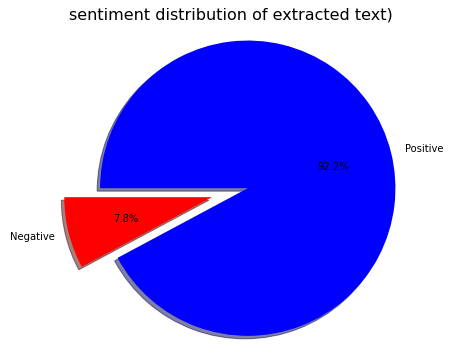

In [24]:
sentiment_count = df_txt.groupby('Sentiment').size()
# plot
labels = 'Negative', 'Positive'
sizes = [sentiment_count[0], sentiment_count[1]]
colors = ['red', 'blue']
explode = (0.25, 0)  # explode 1st slice
fig = plt.figure(figsize=[8, 6])

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=180)

plt.axis('equal')
plt.title("sentiment distribution of extracted text)", fontsize=16)
plt.show()



# Word Cloud

In [25]:
# Function to plot word cloud
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,12.0), 
                   title = None, title_size=18, image_color=False):

    wordcloud = WordCloud(background_color='white',
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    
    if image_color:
        #image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'center'})
    plt.axis('off');
    plt.tight_layout()  

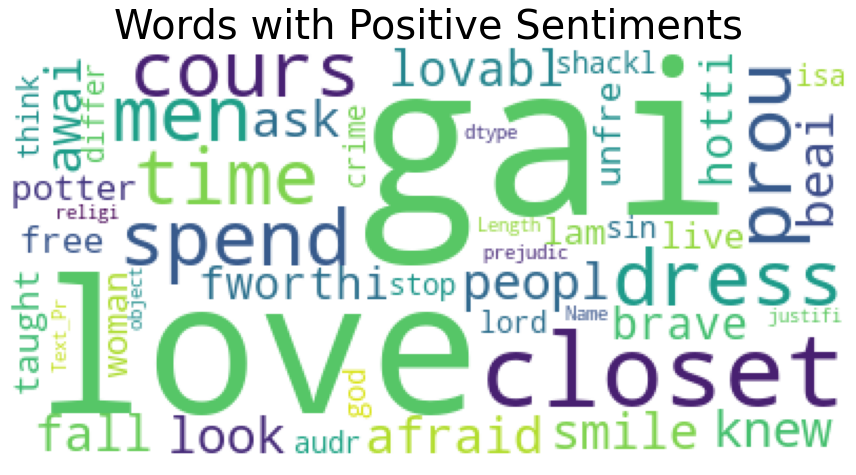

In [30]:
txt = str( df_txt[df_txt['Sentiment'] == 'Positive'].Text_Pr )
plot_wordcloud(txt, max_words=400, max_font_size=100, 
               title = 'Words with Positive Sentiments', title_size=40)

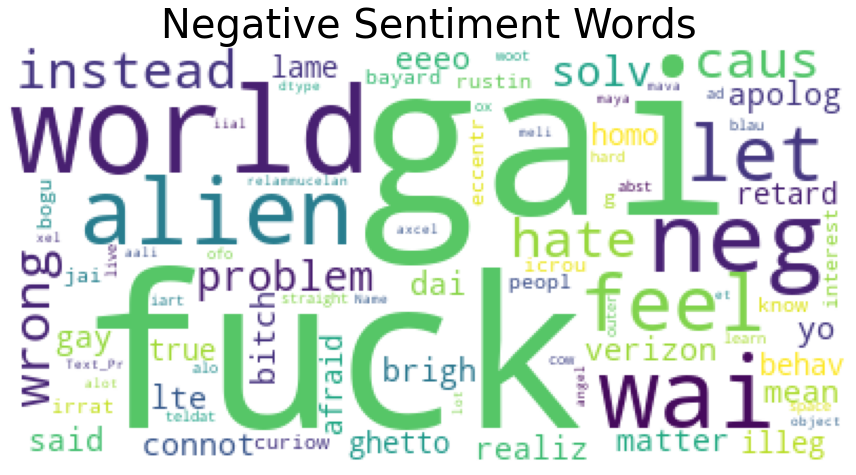

In [31]:
txt = str( df_txt[df_txt['Sentiment'] == 'Negative'].Text_Pr )
plot_wordcloud(txt, max_words=300, max_font_size=100, 
               title = 'Negative Sentiment Words', title_size=40)